In [130]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.svm import LinearSVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
%matplotlib inline

plt.show(block=True)
sns.set(style="darkgrid", rc={'figure.figsize':(19, 4)})

Carga de datos usando como Índice la columna tiempo (*time*). Mostramos las primeras 3 líneas para verificar la carga correcta de datos.

In [65]:
data = pd.read_csv("BD_Mantenimiento.csv", parse_dates=True, index_col = 'time')
data.head(3)

,ID,CV.005,CV.006,CV.007,P1.CV.005,P2.CV.005,CH1,CH2,VEL_FEEDER_220,VEL_FEEDER_225,VEL_FEEDER_230,VEL_FEEDER_235,TORQUE_P5,TORQUE_P6,TORQUE_P7,FEEDER_12_ON_OFF,FEEDER_14_ON_OFF,FEEDER_16_ON_OFF,FEEDER_18_ON_OFF
time,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,-7980.000,-9100.868,-4527.254,10106.000,9334.00,15.17791,28.75353,98.0,79.0,91.0,0.0,-282.0000,-324.1891,-159.9308,FUNCIONANDO,FUNCIONANDO,FUNCIONANDO,DETENIDO
2018-01-01 00:05:00,2,-7565.047,-9046.918,-4525.219,9879.120,9101.42,14.50920,24.82083,98.0,79.0,91.0,0.0,-271.5300,-315.7920,-160.2237,FUNCIONANDO,FUNCIONANDO,FUNCIONANDO,DETENIDO
2018-01-01 00:10:00,3,-7480.847,-8852.079,-4678.155,9820.364,9074.35,14.45478,21.33711,98.0,79.0,91.0,0.0,-263.1521,-310.9880,-169.6160,FUNCIONANDO,FUNCIONANDO,FUNCIONANDO,DETENIDO


A continuación verificamos la ventana temporal de los datos

In [29]:
data.index.max() - data.index.min()

Timedelta('561 days 20:00:00')

# EDA

Graficaremos las correas regenerativas como en función del tiempo para observar la data disponible

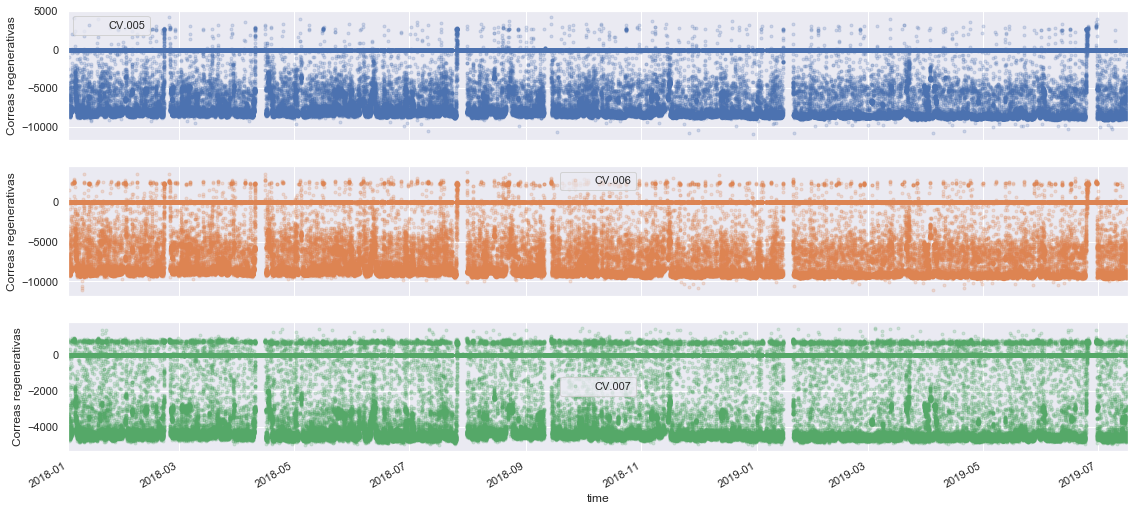

In [30]:
cols_plot = ['CV.005', 'CV.006', 'CV.007']

axes = data[cols_plot].plot(marker='.', alpha=0.2, linestyle='None', figsize=(19, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Correas regenerativas')

Observamos la distribución de los datos de las variables objetivo: CV.005, CV.006 y CV.007, sin considerar los ceros para observar mejor las distribuciones. 

Se ve que la mayoría de los datos son valores negativos entre los rangos -10.000 y -5.000

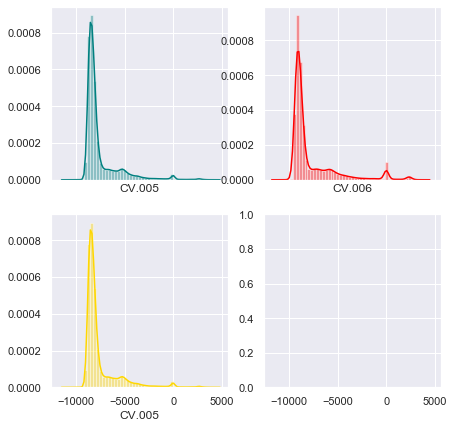

In [37]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
data_nonzero = data.copy()
data_nonzero = data_nonzero.replace(0, np.nan) 
sns.distplot( data_nonzero['CV.005'].dropna() , color="teal", label="Tonnage", ax=axes[0, 0])
sns.distplot( data_nonzero['CV.006'].dropna() , color="red", label="Mean", ax=axes[0, 1])
sns.distplot( data_nonzero['CV.005'].dropna(), color="gold", label="Median", ax=axes[1, 0])

A continuación graficaremos las variables de chancadores (CH1 y CH2)

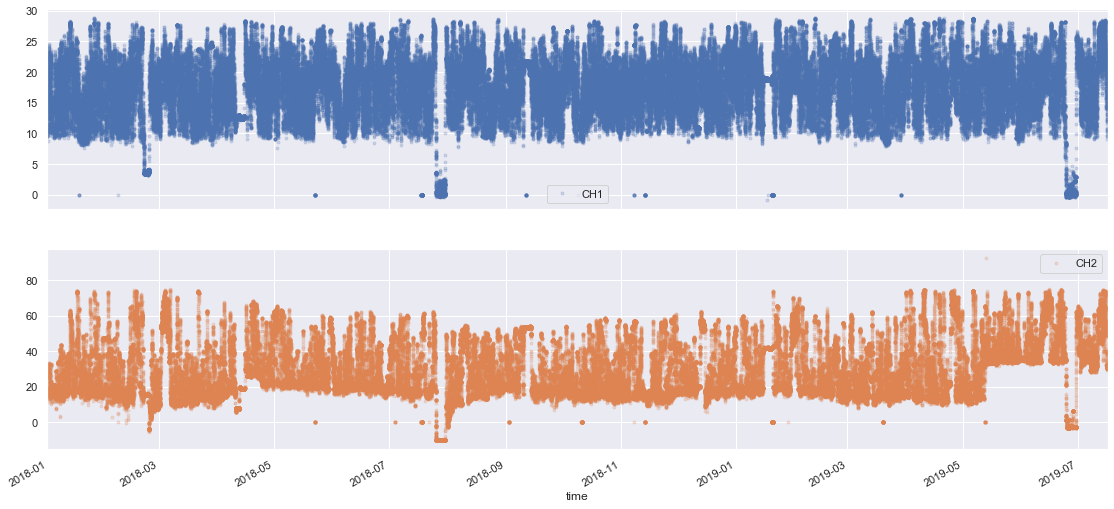

In [41]:
cols_plot = ['CH1', 'CH2']

axes = data[cols_plot].plot(marker='.', alpha=0.2, linestyle='None', figsize=(19, 9), subplots=True)

A continuación graficamos los pesómetros P1.CV.005 y P2.CV.005

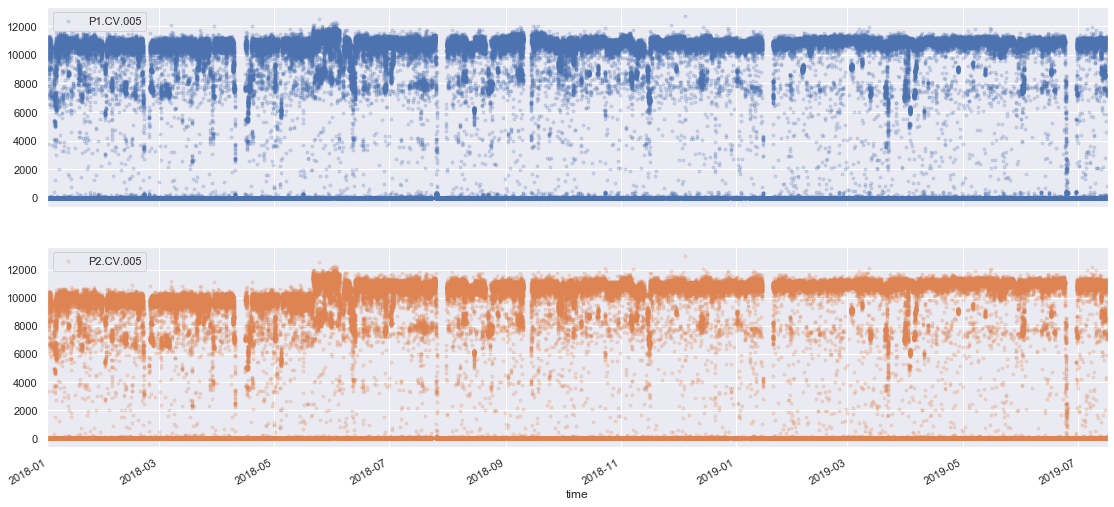

In [43]:
cols_plot = ['P1.CV.005', 'P2.CV.005']

axes = data[cols_plot].plot(marker='.', alpha=0.2, linestyle='None', figsize=(19, 9), subplots=True)

Ahora, graficaremos las velocidades de los alimentadores

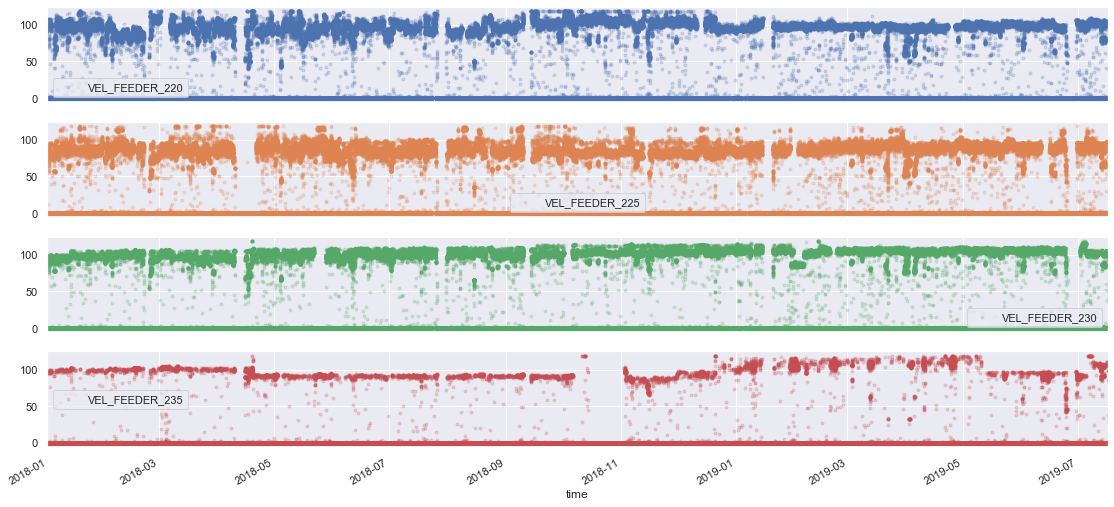

In [45]:
cols_plot = ['VEL_FEEDER_220', 'VEL_FEEDER_225', 'VEL_FEEDER_230', 'VEL_FEEDER_235']

axes = data[cols_plot].plot(marker='.', alpha=0.2, linestyle='None', figsize=(19, 9), subplots=True)

A continuación, se despliega las variables de los torques

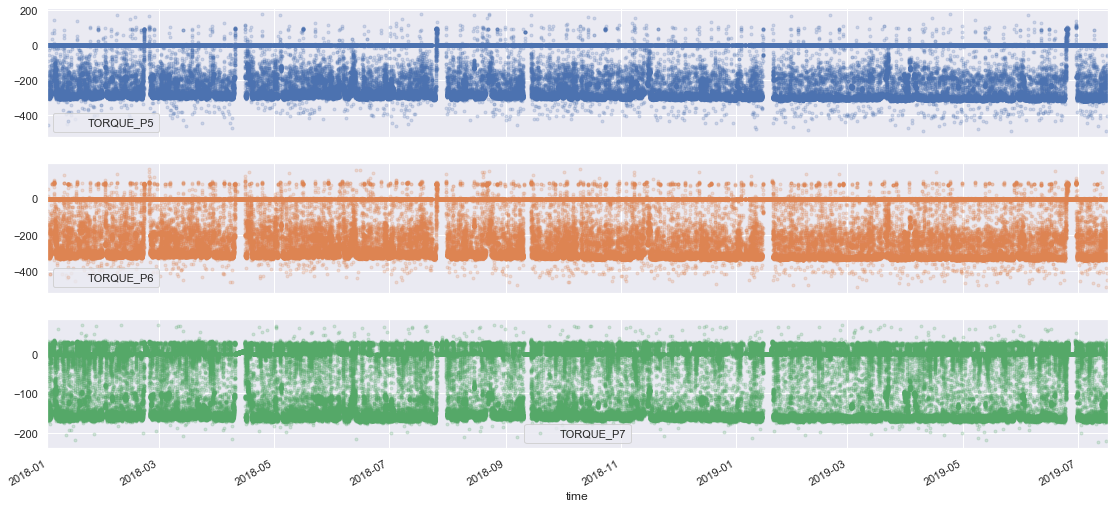

In [46]:
cols_plot = ['TORQUE_P5', 'TORQUE_P6', 'TORQUE_P7']

axes = data[cols_plot].plot(marker='.', alpha=0.2, linestyle='None', figsize=(19, 9), subplots=True)

Finalmente, graficamos las variables de estado de los alimentadores

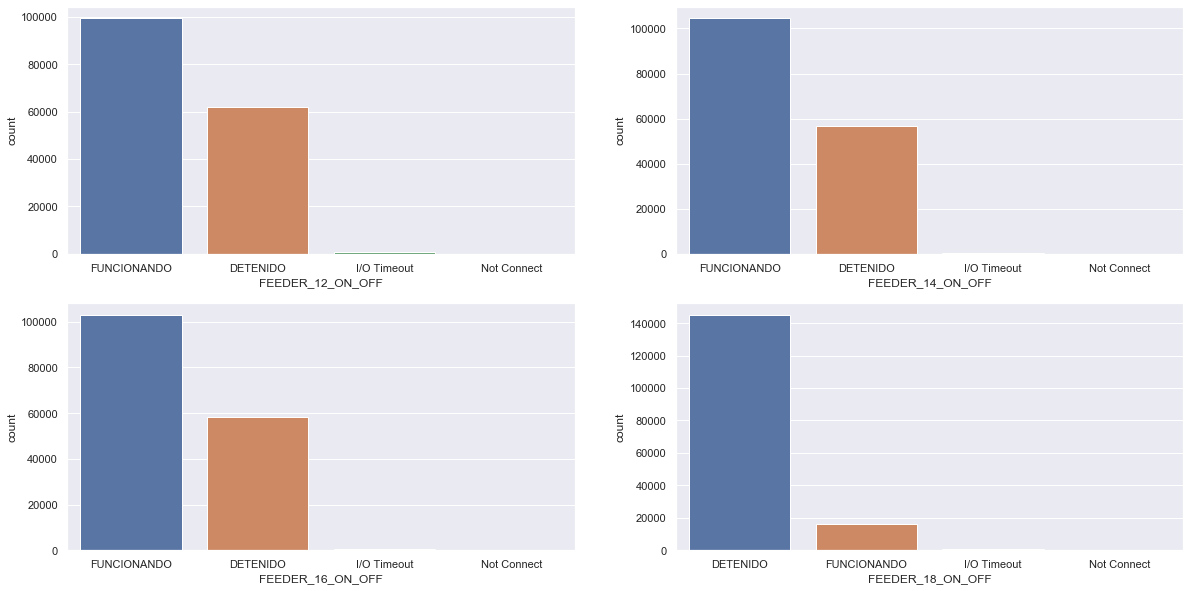

In [52]:
fig, ax = plt.subplots(2,2)
sns.set(style="darkgrid", rc={'figure.figsize':(20, 10)})

sns.countplot(data['FEEDER_12_ON_OFF'], label="Count", ax=ax[0, 0])
sns.countplot(data['FEEDER_14_ON_OFF'], label="Count", ax=ax[0, 1])
sns.countplot(data['FEEDER_16_ON_OFF'], label="Count", ax=ax[1, 0])
sns.countplot(data['FEEDER_18_ON_OFF'], label="Count", ax=ax[1, 1])

## Filtro de datos
Dado el gráfico de los alimentadores, se observa que las categorías "I/O Timeout" y "Not Connect" no son representativas, por lo que no serán consideradas en el análisis (Fuera del alcance). Dejando sólo dos categorías por alimentador: FUNCIONANDO y DETENIDO

In [56]:
data_count_pre = data.size
data = data.loc[data['FEEDER_12_ON_OFF'] != 'I/O Timeout']
data = data.loc[data['FEEDER_12_ON_OFF'] != 'Not Connect']
data = data.loc[data['FEEDER_14_ON_OFF'] != 'I/O Timeout']
data = data.loc[data['FEEDER_14_ON_OFF'] != 'Not Connect']
data = data.loc[data['FEEDER_16_ON_OFF'] != 'I/O Timeout']
data = data.loc[data['FEEDER_16_ON_OFF'] != 'Not Connect']
data = data.loc[data['FEEDER_18_ON_OFF'] != 'I/O Timeout']
data = data.loc[data['FEEDER_18_ON_OFF'] != 'Not Connect']
data_count_post = data.size
print("La cantidad de datos eliminados son {} de {} que corresponde a {}%".format(data_count_pre-data_count_post, data_count_pre, (data_count_pre-data_count_post)/data_count_pre * 100))

La cantidad de datos eliminados son 10982 de 3074599 que corresponde a 0.35718479060196145%


# Análisis Temporal

Es necesario analizar la distribución temporal del muestreo de las variables, se hará un análisis por minuto

In [57]:
deltaT = data.index.to_series().diff().dt.total_seconds().div(60, fill_value=0)

In [58]:
deltaT.describe()

count    161243.000000
mean          5.017520
std           3.276519
min         -55.000000
25%           5.000000
50%           5.000000
75%           5.000000
max        1230.000000
Name: time, dtype: float64

Se observa que la mayor parte de los datos están muestreados a 5 minutos

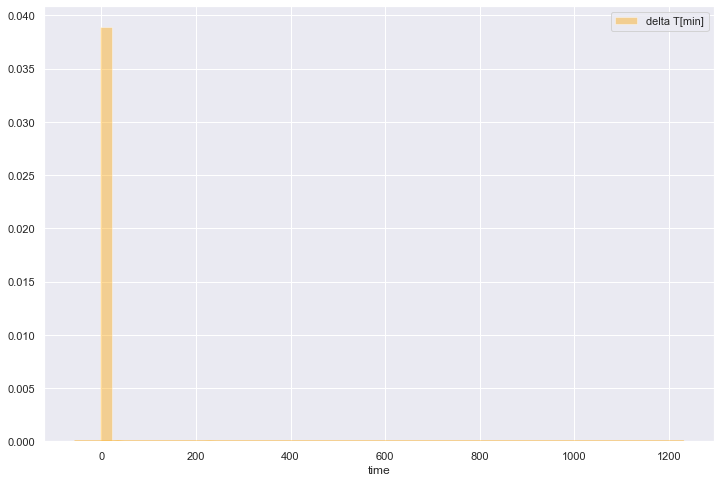

In [61]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.distplot(deltaT , color="orange", label="delta T[min]")
plt.legend()

# Correlación

Al distinguir las variables, tipos de datos y sus características, se hace útil analizar la correlación entre variables. Para ellos usamos la matriz de correlación que se calcula a continuación.

In [73]:
corr_vars = ['CH1', 'CH2', 'CV.005', 'CV.006', 'CV.007', 'P1.CV.005', 'P2.CV.005', 'TORQUE_P5', 'TORQUE_P6', 'TORQUE_P7',
            'VEL_FEEDER_220', 'VEL_FEEDER_225', 'VEL_FEEDER_230', 'VEL_FEEDER_235']

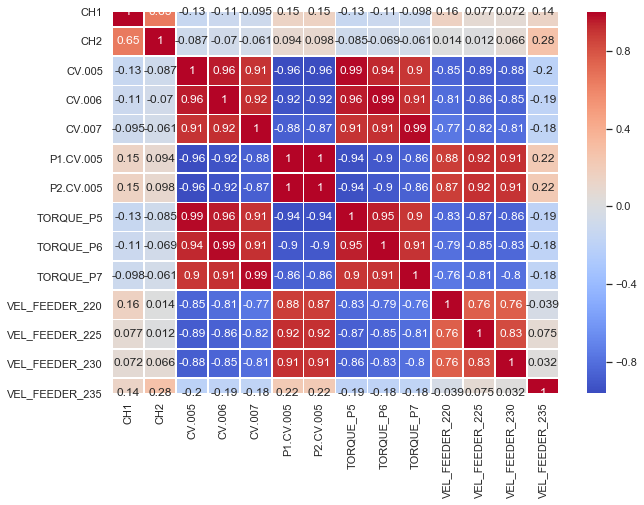

In [74]:
f, ax = plt.subplots(figsize=(10, 7))
corr_data = data[corr_vars].copy()
sns.heatmap(corr_data.corr(), annot=True, linewidths=0.5, cmap='coolwarm', ax=ax)

En esta matriz, ya se observa fuerte correlación (sobre 0.8) entre variables TORQUE, ALIMENTADORES (FEEDER) y variables Target (CV.005, CV.006 y CV.007)

# Predicción

Se hara uso de algunos algoritmos de aprendizaje supervisado para realizar la predicción de las distintas variables objetivo.

In [77]:
cv05 = data['CV.005'].copy()
cv06 = data['CV.006'].copy()
cv07 = data['CV.007'].copy()

In [78]:
target_vars = ['CV.005', 'CV.006', 'CV.007']
predictoras_continuas  = ['P1.CV.005', 'P2.CV.005', 'CH1', 'CH2', 'VEL_FEEDER_220', 'VEL_FEEDER_225',
                          'VEL_FEEDER_230', 'VEL_FEEDER_235', 'TORQUE_P5', 'TORQUE_P6', 'TORQUE_P7']
predictoras_categorica = ['FEEDER_12_ON_OFF', 'FEEDER_14_ON_OFF', 'FEEDER_16_ON_OFF', 'FEEDER_18_ON_OFF']

Aquellas variables de estado (categóricas) serán binarizadas para un mejor uso

In [80]:
feeders = data[predictoras_categorica].copy() 

lb_make = LabelEncoder()
feeders["FEEDER_12_ON_OFF_CODE"] = lb_make.fit_transform(feeders["FEEDER_12_ON_OFF"])
feeders["FEEDER_14_ON_OFF_CODE"] = lb_make.fit_transform(feeders["FEEDER_14_ON_OFF"])
feeders["FEEDER_16_ON_OFF_CODE"] = lb_make.fit_transform(feeders["FEEDER_16_ON_OFF"])
feeders["FEEDER_18_ON_OFF_CODE"] = lb_make.fit_transform(feeders["FEEDER_18_ON_OFF"])

feeders_converted = ['FEEDER_12_ON_OFF_CODE', 'FEEDER_14_ON_OFF_CODE', 'FEEDER_16_ON_OFF_CODE', 'FEEDER_18_ON_OFF_CODE']
feeders_dummies = feeders[feeders_converted].copy()

Preparamos los datos

In [81]:
predictoras = data[predictoras_continuas].copy()

In [91]:
X = pd.concat([feeders_dummies, predictoras], axis=1)
Y05 = cv05.copy()
Y06 = cv06.copy()
Y07 = cv07.copy()

Hacemos una separación de datos Target y Test usando un 34% de los datos, usando semillas distintas

In [96]:
seed05 = 250519
seed06 = 111080
seed07 = 110484
test_size = 0.34

In [97]:
X_train05, X_test05, y_train05, y_test05 = train_test_split(X, Y05, test_size=test_size, random_state=seed05)
X_train06, X_test06, y_train06, y_test06 = train_test_split(X, Y06, test_size=test_size, random_state=seed06)
X_train07, X_test07, y_train07, y_test07 = train_test_split(X, Y07, test_size=test_size, random_state=seed07)

## Support Vector Machine

Usamos LinearSVM como primer regresor, a continuación se entrena la máquina y se predice. Usamos hiperparámetros estandar.

In [113]:
print('Starting training CV.05 ...')
svm05=LinearSVR(random_state=0, tol=1e-5)
svm05.fit(X_train05, y_train05)

print('Starting training CV.06 ...')
svm06=LinearSVR(random_state=0, tol=1e-5)
svm06.fit(X_train06, y_train06)

print('Starting training CV.07 ...')
svm07=LinearSVR(random_state=0, tol=1e-5)
svm07.fit(X_train07, y_train07)

Starting training CV.05 ...
Starting training CV.06 ...
Starting training CV.07 ...


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=1e-05, verbose=0)

Ahora, predecimos los conjuntos de test para cada variable

In [135]:
y_pred05 = svm05.predict(X_test05)
y_pred06 = svm06.predict(X_test06)
y_pred07 = svm07.predict(X_test07)

Graficamos los resultados

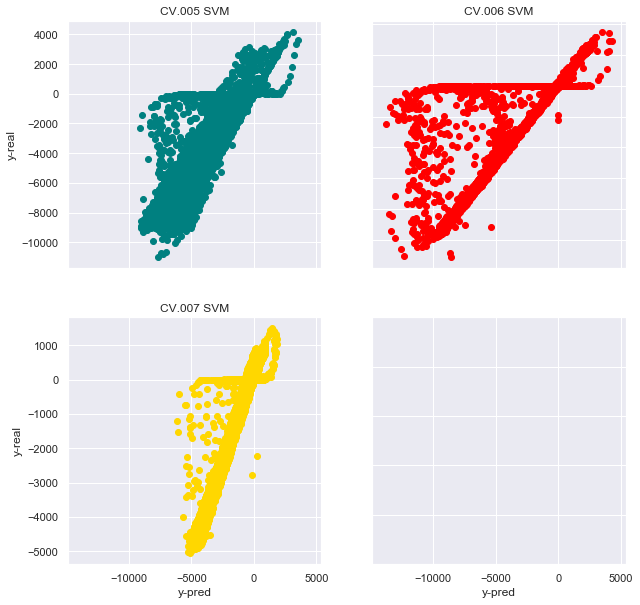

In [136]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

axes[0, 0].scatter(y_pred05, y_test05,  color='teal')
axes[0, 0].set_title('CV.005 SVM')
axes[0, 1].scatter(y_pred06, y_test06,  color='red')
axes[0, 1].set_title('CV.006 SVM')
axes[1, 0].scatter(y_pred07, y_test07,  color='gold')
axes[1, 0].set_title('CV.007 SVM')

for ax in axes.flat:
    ax.set(xlabel='y-pred', ylabel='y-real')

for ax in axes.flat:
    ax.label_outer()

Calculamos las métricas Pearson, Spearman y R2

In [137]:
print("CV.005 - Pearson: {}, Spearman: {}, R2: {}".format(pearsonr(y_test05, y_pred05)[0], spearmanr(y_test05, y_pred05)[0], r2_score(y_test05, y_pred05)))
print("CV.006 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test06, y_pred06)[0], spearmanr(y_test06, y_pred06)[0], r2_score(y_test06, y_pred06)))
print("CV.007 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test07, y_pred07)[0], spearmanr(y_test07, y_pred07)[0], r2_score(y_test07, y_pred07)))

CV.005 - Pearson: 0.9910443742598708, Spearman: 0.9567315974808638, R2: 0.9816987231479044
CV.006 - Pearson: 0.987754599593396, Spearman: 0.9685800907165395, R2: 0.9749792100232856
CV.007 - Pearson: 0.9914884196216907, Spearman: 0.9272944778110903, R2: 0.9800892549249192


## Linear Regression

Usamos LinearRegression como siguiente regresor, a continuación se entrena la máquina y se predice. Usamos componentes estandar.

In [142]:
LR05=LinearRegression()
LR06=LinearRegression() 
LR07=LinearRegression()

LR05.fit(X_train05, y_train05)
LR06.fit(X_train06, y_train06)
LR07.fit(X_train07, y_train07)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Ahora, predecimos los conjuntos de test para cada variable

In [143]:
y_pred05 = LR05.predict(X_test05)
y_pred06 = LR06.predict(X_test06)
y_pred07 = LR07.predict(X_test07)

Graficamos los resultados para LR

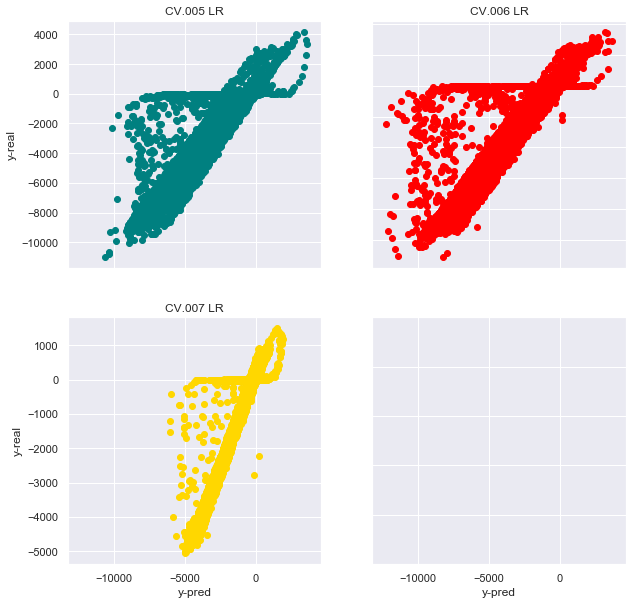

In [144]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

axes[0, 0].scatter(y_pred05, y_test05,  color='teal')
axes[0, 0].set_title('CV.005 LR')
axes[0, 1].scatter(y_pred06, y_test06,  color='red')
axes[0, 1].set_title('CV.006 LR')
axes[1, 0].scatter(y_pred07, y_test07,  color='gold')
axes[1, 0].set_title('CV.007 LR')

for ax in axes.flat:
    ax.set(xlabel='y-pred', ylabel='y-real')

for ax in axes.flat:
    ax.label_outer()

Calculamos las métricas Pearson, Spearman y R2

In [145]:
print("CV.005 - Pearson: {}, Spearman: {}, R2: {}".format(pearsonr(y_test05, y_pred05)[0], spearmanr(y_test05, y_pred05)[0], r2_score(y_test05, y_pred05)))
print("CV.006 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test06, y_pred06)[0], spearmanr(y_test06, y_pred06)[0], r2_score(y_test06, y_pred06)))
print("CV.007 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test07, y_pred07)[0], spearmanr(y_test07, y_pred07)[0], r2_score(y_test07, y_pred07)))

CV.005 - Pearson: 0.9924232117324734, Spearman: 0.9698796925042791, R2: 0.9849031169795665
CV.006 - Pearson: 0.9901793732310404, Spearman: 0.9672036698633651, R2: 0.9804548798274438
CV.007 - Pearson: 0.9922116705966894, Spearman: 0.9634316508669662, R2: 0.984474752026237


## Light GBM
Usamos lightgbm como ultimo predictor. Para ello se crean dataset específicos del toolkit

In [146]:
# create dataset for cv05
lgb_train05 = lgb.Dataset(X_train05, y_train05)
lgb_eval05 = lgb.Dataset(X_test05, y_test05, reference=lgb_train05)
# create dataset for cv06
lgb_train06 = lgb.Dataset(X_train06, y_train06)
lgb_eval06 = lgb.Dataset(X_test06, y_test06, reference=lgb_train06)
# create dataset for cv07
lgb_train07 = lgb.Dataset(X_train07, y_train07)
lgb_eval07 = lgb.Dataset(X_test07, y_test07, reference=lgb_train07)

In [147]:
# Especificamos parametros 
params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': {'l2', 'l1'},
'num_leaves': 1000,
'learning_rate': 0.1,
'feature_fraction': 0.9,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'verbose': 0
}

In [148]:
print('Starting training CV.05 ...')
# train 05
gbm05 = lgb.train(params,
                  lgb_train05,
                  num_boost_round=50,
                  valid_sets=lgb_eval05,
                  early_stopping_rounds=5,
                  verbose_eval=False)

print('Starting training CV.06 ...')
# train 06
gbm06 = lgb.train(params,
                  lgb_train06,
                  num_boost_round=50,
                  valid_sets=lgb_eval06,
                  early_stopping_rounds=5,
                  verbose_eval=False)

print('Starting training CV.07 ...')
# train 07
gbm07 = lgb.train(params,
                  lgb_train07,
                  num_boost_round=50,
                  valid_sets=lgb_eval07,
                  early_stopping_rounds=5,
                  verbose_eval=False)

Starting training CV.05 ...
Starting training CV.06 ...
Starting training CV.07 ...


Ahora, predecimos los conjuntos de test para cada variable

In [149]:
y_pred05 = gbm05.predict(X_test05)
y_pred06 = gbm06.predict(X_test06)
y_pred07 = gbm07.predict(X_test07)

Graficamos los resultados para LR

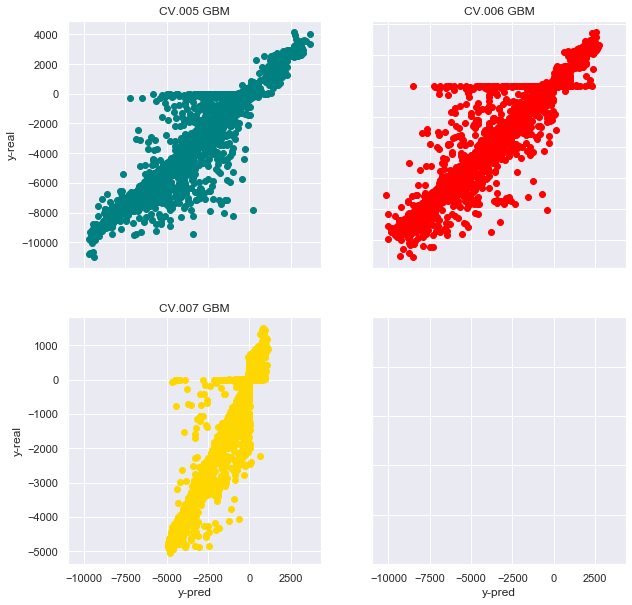

In [150]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

axes[0, 0].scatter(y_pred05, y_test05,  color='teal')
axes[0, 0].set_title('CV.005 GBM')
axes[0, 1].scatter(y_pred06, y_test06,  color='red')
axes[0, 1].set_title('CV.006 GBM')
axes[1, 0].scatter(y_pred07, y_test07,  color='gold')
axes[1, 0].set_title('CV.007 GBM')

for ax in axes.flat:
    ax.set(xlabel='y-pred', ylabel='y-real')

for ax in axes.flat:
    ax.label_outer()

Calculamos las métricas Pearson, Spearman y R2

In [151]:
print("CV.005 - Pearson: {}, Spearman: {}, R2: {}".format(pearsonr(y_test05, y_pred05)[0], spearmanr(y_test05, y_pred05)[0], r2_score(y_test05, y_pred05)))
print("CV.006 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test06, y_pred06)[0], spearmanr(y_test06, y_pred06)[0], r2_score(y_test06, y_pred06)))
print("CV.007 - Pearson: {}, Spearman: {}, R2: {}". format(pearsonr(y_test07, y_pred07)[0], spearmanr(y_test07, y_pred07)[0], r2_score(y_test07, y_pred07)))

CV.005 - Pearson: 0.9976720203763788, Spearman: 0.9830422881598927, R2: 0.9953208615533663
CV.006 - Pearson: 0.997698771397633, Spearman: 0.9764581694106897, R2: 0.995353954031624
CV.007 - Pearson: 0.9977284424147437, Spearman: 0.9695927460727826, R2: 0.9954382130140584


In [43]:
print(pearsonr(my_test, my_pred), spearmanr(my_test, my_pred))

(0.9999003860811512, 0.0) SpearmanrResult(correlation=0.9929908894435746, pvalue=0.0)


# Análisis de predicción GBM

GBM, dio los mejores resultados en este experimento, y tiene la ventaja de mostrar la importancia de las variables usadas, a continuación la gráfica de la importancia y los mejores valores asociados.

Se observa en las listas que para cada modelo, las variables de **TORQUE** generalmente son las que más impactan el modelo seguido por la velocidad de los alimentadores. Se destaca en la CV.007 que las potencia de los chancadores (CH1 y CH2) fueron las más relevantes.

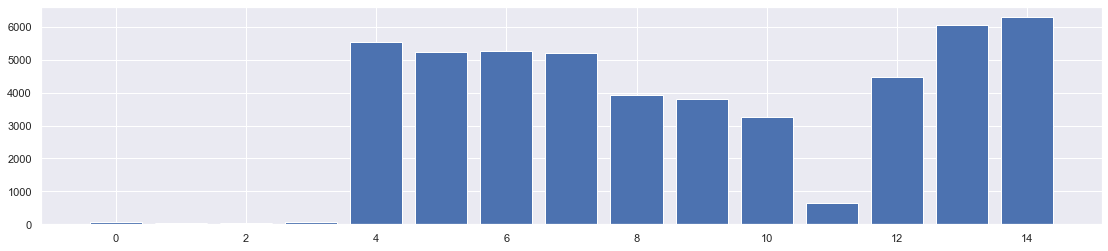

In [184]:
plt.bar(range(len(gbm05.feature_importance())), gbm05.feature_importance())
plt.show()

In [185]:
for i,j in enumerate(gbm05.feature_importance()):
    if j > 40:
        print(X.columns[i], j)

FEEDER_12_ON_OFF_CODE 66
FEEDER_14_ON_OFF_CODE 51
FEEDER_16_ON_OFF_CODE 42
FEEDER_18_ON_OFF_CODE 71
P1.CV.005 5549
P2.CV.005 5247
CH1 5276
CH2 5202
VEL_FEEDER_220 3943
VEL_FEEDER_225 3794
VEL_FEEDER_230 3249
VEL_FEEDER_235 654
TORQUE_P5 4466
TORQUE_P6 6046
TORQUE_P7 6294


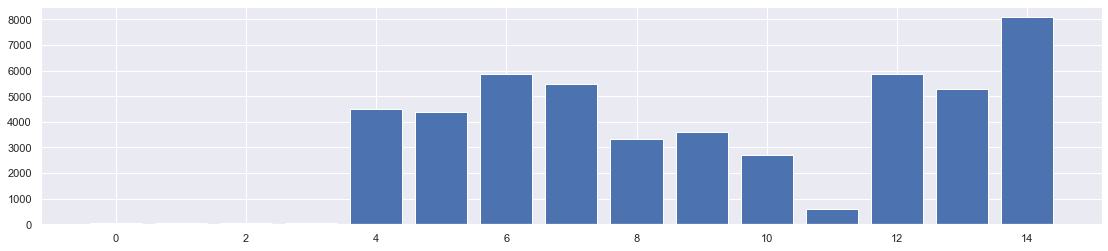

In [186]:
plt.bar(range(len(gbm06.feature_importance())), gbm06.feature_importance())
plt.show()

In [187]:
for i,j in enumerate(gbm06.feature_importance()):
    if j > 40:
        print(X.columns[i], j)

FEEDER_12_ON_OFF_CODE 50
FEEDER_14_ON_OFF_CODE 51
FEEDER_16_ON_OFF_CODE 64
FEEDER_18_ON_OFF_CODE 53
P1.CV.005 4503
P2.CV.005 4379
CH1 5858
CH2 5488
VEL_FEEDER_220 3346
VEL_FEEDER_225 3597
VEL_FEEDER_230 2723
VEL_FEEDER_235 592
TORQUE_P5 5867
TORQUE_P6 5296
TORQUE_P7 8083


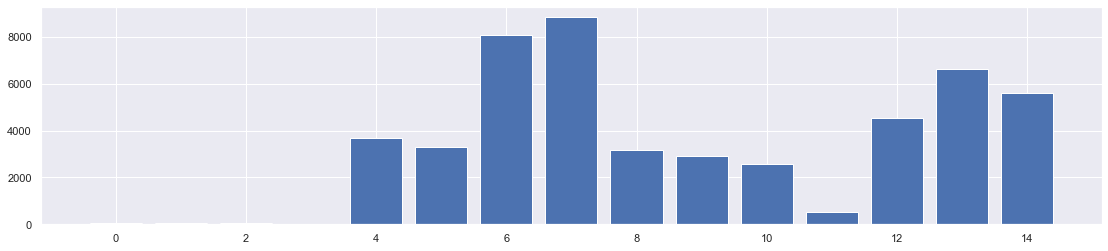

In [188]:
plt.bar(range(len(gbm07.feature_importance())), gbm07.feature_importance())
plt.show()

In [189]:
for i,j in enumerate(gbm07.feature_importance()):
    if j > 40:
        print(X.columns[i], j)

FEEDER_12_ON_OFF_CODE 42
FEEDER_14_ON_OFF_CODE 41
P1.CV.005 3695
P2.CV.005 3281
CH1 8068
CH2 8831
VEL_FEEDER_220 3161
VEL_FEEDER_225 2913
VEL_FEEDER_230 2590
VEL_FEEDER_235 537
TORQUE_P5 4549
TORQUE_P6 6605
TORQUE_P7 5579
